# Import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models.segmentation as segmentation
import segmentation_models_pytorch as smp
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from albumentations.core.composition import Compose

from torchvision import transforms
# import imgaug.augmenters as iaa
from PIL import Image
import imageio
from math import sqrt
from albumentations.core.transforms_interface import DualTransform
from albumentations.core.transforms_interface import BasicTransform
# from pytorch_toolbelt import losses as L
from FisheyeSeg_master.data.FishEyeGenerator import FishEyeGenerator
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

d:\Users\admin\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
import warnings
warnings.filterwarnings("ignore")

# RLE Encoding

In [2]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Custom Dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 255] = 12 #배경을 픽셀값 12로 간주

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# Fisheye Lens Conversion

In [5]:
## 기존 어안 렌즈 변환

# def fish(img, distortion_coefficient, color):
#     h, w = img.shape[:2]
    
#     x, y = np.meshgrid(np.arange(w), np.arange(h))
#     xnd, ynd = (2 * x - w) / w, (2 * y - h) / h
#     rd = np.sqrt(xnd ** 2 + ynd ** 2)
    
#     mask = 1 - distortion_coefficient * (rd ** 2)
#     mask[mask == 0] = 1
#     xdu, ydu = xnd / mask, ynd / mask
    
#     xu, yu = ((xdu + 1) * w / 2).astype(int), ((ydu + 1) * h / 2).astype(int)
#     valid_indices = (0 <= xu) & (xu < w) & (0 <= yu) & (yu < h)
    
#     dstimg = np.zeros_like(img, dtype=np.uint8)
#     dstimg[y[valid_indices], x[valid_indices]] = img[yu[valid_indices], xu[valid_indices]]
#     dstimg[~valid_indices] = color
    
#     return dstimg.astype(np.uint8)

# class Fisheye(DualTransform):
#     def apply(self, img: np.ndarray, distortion_coefficient=1.0, **params) -> np.ndarray:
#         if len(img.shape) == 2:
#             color=12

#         if len(img.shape) == 3 and img.shape[2] == 3:
#             color=[0,0,0]

#         return fish(img, distortion_coefficient,color)  # 어안 렌즈 효과 적용 이미지 생성
    
#     def get_transform_init_args_names(self):
#         return ()

In [6]:
# old_param=None
# old_focal=None

# class FESetsGenerator:
#     def __init__(self, dst_shape, focal_len=350):
#         self._generator = FishEyeGenerator(focal_len, dst_shape)

#         self._F_RAND_FLAG = False
#         self._F_RANGE = [200,350]

#         self._EXT_RAND_FLAG = False
#         self._EXT_PARAM_RANGE = [5, 5, 10, 0.3, 0.3, 0.4]
#         self._generator.set_ext_param_range(self._EXT_PARAM_RANGE)

#     def set_ext_param_range(self,ext_param):
#         for i in range(6):
#             self._EXT_PARAM_RANGE[i] = ext_param[i]
#         self._generator.set_ext_param_range(self._EXT_PARAM_RANGE)

#     def rand_ext_params(self):
#         self._EXT_RAND_FLAG = True

#     def set_ext_params(self,ext_params):
#         self._generator.set_ext_params(ext_params)
#         self._EXT_RAND_FLAG = False

#     def set_f(self, focal_len):
#         self._generator.set_f(focal_len)
#         self._F_RAND_FLAG = False

#     def rand_f(self, f_range=[200,400]):
#         self._F_RANGE = f_range
#         self._F_RAND_FLAG = True

#     def generate(self, img, flag, img_id, old_img_id):
#         global old_focal, old_param
#         src_image = img
#         # print("img_id:",img_id, "old_img_id:",old_img_id)

#         if img_id==old_img_id:
#             self._F_RAND_FLAG=False
#             self._EXT_RAND_FLAG=False
#         else:
#             self._F_RAND_FLAG=True
#             self._EXT_RAND_FLAG=True

#         # print("f_land flag 상태:", self._F_RAND_FLAG,"ext rand flag:" ,self._EXT_RAND_FLAG)

#         if self._F_RAND_FLAG:
#             randf=self._generator.rand_f(self._F_RANGE)
#             old_focal=randf
#         elif not self._F_RAND_FLAG:
#             self._generator.set_f(old_focal)

#         if self._EXT_RAND_FLAG:
#             randext=self._generator.rand_ext_params()
#             # print("ext param true")
#             # self._generator.print_ext_param()
#             old_param=randext
#         elif not self._EXT_RAND_FLAG:
#             [self._generator._alpha, self._generator._beta, self._generator._theta, self._generator._x_trans, self._generator._y_trans, self._generator._z_trans]=old_param
#             # print("ext param false")
#             # self._generator.print_ext_param()

#         # print(f"old_focal:{old_focal}, old_param:{old_param}")

#         if flag==3:
#             result = self._generator.transFromColor(src_image)
#         if flag==0:
#             result = self._generator.transFromGray(src_image)

#         return result.astype(np.uint8)

In [7]:
# cnt=0
# old_img_path="None"

# class Fisheye(DualTransform):
#     def __init__(self, csv_path="./train_source.csv", **kwargs):
#         super().__init__(**kwargs)
#         self.csv_path = csv_path
#         data = pd.read_csv(csv_path)

#         self.img_paths = data['id'].tolist()
#         # print(self.img_paths)

#     def apply(self, img: np.ndarray, dst_size=[1024, 2048], focal_len=200, ext_param=[5, 5, 10, 0.3, 0.3, 0.4], **params) -> np.ndarray:
#         global cnt, old_img_path

#         if cnt < len(self.img_paths):
#             self.img_path = self.img_paths[cnt]
#         else:
#             cnt=0

#         if self.img_path==old_img_path:
#             cnt+=1
     
#         DT = FESetsGenerator(dst_size, focal_len)
#         DT.set_ext_param_range(ext_param)
#         DT.rand_ext_params()
#         DT.rand_f()

#         if len(img.shape) == 2:
#             flag = 0
#         elif len(img.shape) == 3 and img.shape[2] == 3:
#             flag = 3
#         else:
#             raise ValueError("Unsupported image shape")
        
#         fe=DT.generate(img, flag, self.img_path, old_img_path)

#         old_img_path=self.img_path

#         return fe

#     def get_transform_init_args_names(self):
#         return ('csv_path', 'epoch')

In [4]:
# old_param=None
# old_focal=None
# cnt=0
# old_img_path="None"
# dst_size=[1024,2048]
# focal_len=350

# class Fisheye(DualTransform):
#     def __init__(self, csv_path="./train_source.csv", **kwargs):
#         global dst_size, focal_len
#         super().__init__(**kwargs)
#         self.csv_path = csv_path
#         data = pd.read_csv(csv_path)

#         self.img_paths = data['id'].tolist()

#         self._generator = FishEyeGenerator(focal_len, dst_size)

#         self._F_RAND_FLAG = False
#         self._F_RANGE = [200,350]

#         self._EXT_RAND_FLAG = False
#         self._EXT_PARAM_RANGE = [5, 5, 10, 0.3, 0.3, 0.4]
#         self._generator.set_ext_param_range(self._EXT_PARAM_RANGE)
#         # print(self.img_paths)

#     def set_ext_param_range(self,ext_param):
#         for i in range(6):
#             self._EXT_PARAM_RANGE[i] = ext_param[i]
#         self._generator.set_ext_param_range(self._EXT_PARAM_RANGE)

#     def rand_ext_params(self):
#         self._EXT_RAND_FLAG = True

#     def set_ext_params(self,ext_params):
#         self._generator.set_ext_params(ext_params)
#         self._EXT_RAND_FLAG = False

#     def set_f(self, focal_len):
#         self._generator.set_f(focal_len)
#         self._F_RAND_FLAG = False

#     def rand_f(self, f_range=[200,400]):
#         self._F_RANGE = f_range
#         self._F_RAND_FLAG = True

#     def generate(self, img, flag, img_id, old_img_id):
#         global old_focal, old_param
#         src_image = img
#         # print("img_id:",img_id, "old_img_id:",old_img_id)

#         if img_id==old_img_id:
#             self._F_RAND_FLAG=False
#             self._EXT_RAND_FLAG=False
#         else:
#             self._F_RAND_FLAG=True
#             self._EXT_RAND_FLAG=True

#         # print("f_land flag 상태:", self._F_RAND_FLAG,"ext rand flag:" ,self._EXT_RAND_FLAG)

#         if self._F_RAND_FLAG:
#             randf=self._generator.rand_f(self._F_RANGE)
#             old_focal=randf
#         elif not self._F_RAND_FLAG:
#             self._generator.set_f(old_focal)

#         if self._EXT_RAND_FLAG:
#             randext=self._generator.rand_ext_params()
#             # print("ext param true")
#             # self._generator.print_ext_param()
#             old_param=randext
#         elif not self._EXT_RAND_FLAG:
#             [self._generator._alpha, self._generator._beta, self._generator._theta, self._generator._x_trans, self._generator._y_trans, self._generator._z_trans]=old_param
#             # print("ext param false")
#             # self._generator.print_ext_param()

#         # print(f"old_focal:{old_focal}, old_param:{old_param}")

#         if flag==3:
#             result = self._generator.transFromColor(src_image)
#         if flag==0:
#             result = self._generator.transFromGray(src_image)

#         return result.astype(np.uint8)
    
#     def apply(self, img: np.ndarray, dst_size=[1024, 2048], focal_len=200, ext_param=[5, 5, 10, 0.3, 0.3, 0.4], **params) -> np.ndarray:
#         global cnt, old_img_path

#         if cnt < len(self.img_paths):
#             self.img_path = self.img_paths[cnt]
#         else:
#             cnt=0

#         if self.img_path==old_img_path:
#             cnt+=1
     
#         DT = self._generator
#         DT.set_ext_param_range(ext_param)
#         DT.rand_ext_params()
#         DT.rand_f()

#         if len(img.shape) == 2:
#             flag = 0
#         elif len(img.shape) == 3 and img.shape[2] == 3:
#             flag = 3
#         else:
#             raise ValueError("Unsupported image shape")
        
#         fe=self.generate(img, flag, self.img_path, old_img_path)

#         old_img_path=self.img_path

#         return fe

#     def get_transform_init_args_names(self):
#         return ('csv_path', 'epoch')

old_param=None
old_focal=None
cnt=0
old_img_path="None"

class Fisheye(DualTransform):
    def __init__(self, csv_path="./train_source.csv", focal_len=350, dst_size=[1024, 2048], **kwargs):
        super().__init__(**kwargs)
        self.csv_path = csv_path
        data = pd.read_csv(csv_path)
        self.img_paths = data['id'].tolist()
        # self.focal_len=focal_len

        self._generator = FishEyeGenerator(focal_len, dst_size)
        self._F_RANGE = [200, 350]
        self._EXT_PARAM_RANGE = [5, 5, 10, 0.3, 0.3, 0.4]

    def set_ext_param_range(self, ext_param):
        self._EXT_PARAM_RANGE = ext_param
        self._generator.set_ext_param_range(ext_param)

    def rand_ext_params(self):
        self._generator.rand_ext_params()

    def set_ext_params(self, ext_params):
        self._generator.set_ext_params(ext_params)

    def set_f(self, focal_len):
        # global focal_leng
        # print(type(focal_len))
        self._generator.set_f(focal_len)

    def rand_f(self, f_range=[200, 400]):
        self._F_RANGE = f_range
        self._generator.rand_f(f_range)

    def generate(self, img, flag, img_id, old_img_id):
        global old_param, old_focal, old_img_path
        src_image = img

        if img_id==old_img_id:
            self._F_RAND_FLAG=False
            self._EXT_RAND_FLAG=False
        else:
            self._F_RAND_FLAG=True
            self._EXT_RAND_FLAG=True

        # print("f_land flag 상태:", self._F_RAND_FLAG,"ext rand flag:" ,self._EXT_RAND_FLAG)

        if self._F_RAND_FLAG:
            randf=self._generator.rand_f(self._F_RANGE)
            old_focal=randf
        elif not self._F_RAND_FLAG:
            self._generator.set_f(old_focal)

        if self._EXT_RAND_FLAG:
            randext=self._generator.rand_ext_params()
            # print("ext param true")
            # self._generator.print_ext_param()
            old_param=randext
        elif not self._EXT_RAND_FLAG:
            [self._generator._alpha, self._generator._beta, self._generator._theta, self._generator._x_trans, self._generator._y_trans, self._generator._z_trans]=old_param
            # print("ext param false")
            # self._generator.print_ext_param()

        if flag == 3:
            result = self._generator.transFromColor(src_image)
        elif flag == 0:
            result = self._generator.transFromGray(src_image)
        else:
            raise ValueError("Unsupported image flag")

        return result.astype(np.uint8)

    def apply(self, img: np.ndarray, **params) -> np.ndarray:
        global cnt, old_img_path
        if cnt < len(self.img_paths):
            self.img_path = self.img_paths[cnt]
        else:
            cnt = 0

        if self.img_path == old_img_path:
            cnt += 1

        if len(img.shape) == 2:
            flag = 0
        elif len(img.shape) == 3 and img.shape[2] == 3:
            flag = 3
        else:
            raise ValueError("Unsupported image shape")

        fe = self.generate(img, flag, self.img_path, old_img_path)
        old_img_path = self.img_path
        return fe

    def get_transform_init_args_names(self):
        return ('csv_path', 'focal_len', 'dst_size')


# Check Data Augmentation

In [9]:
# for epoch in tqdm(range(50)): # 에폭

#     # 데이터 증강을 위한 transform 파이프라인 정의
#     transform = A.Compose([
#         # A.ColorJitter(p=0.3),
#         # A.Downscale(p=0.3),
#         # A.Equalize(p=0.3),
#         # A.HueSaturationValue(p=0.3),
#         # A.ToGray(p=0.15),
#         Fisheye(p=1.0),
#         # A.Spatter(p=1.0),
#         # A.Defocus(p=1.0),
#         # # A.Perspective(p=1.0),
#         # # A.CenterCrop(height=672,width=1344,p=1.0),
#         # A.Resize(512, 1024),
#         # A.Normalize(),
#         # ToTensorV2()
#     ])
#     dataset = CustomDataset(csv_file='./train_source.csv') # dataset 불러오기
#     aug_dataset = CustomDataset(csv_file='./train_source.csv', transform=transform) # dataset 불러오기

#     image,mask=dataset.__getitem__(epoch)
#     aug_image,aug_mask=aug_dataset.__getitem__(epoch)

#     # print(aug_image.size())
#     # print(aug_mask.size())

#     plt.figure(figsize=(15,10))
#     plt.subplot(1, 3, 1)
#     plt.imshow(image)
#     plt.title("Original Image")

#     plt.subplot(1, 3, 2)
#     # plt.imshow(aug_image)
#     plt.imshow(aug_image.transpose(0,1,2))  # Transpose to (height, width, channels)
#     plt.title("Augmented Image")

#     plt.subplot(1, 3, 3)
#     # plt.imshow(aug_mask)
#     plt.imshow(aug_mask)  # 이미지의 차원 순서가 (height, width, channels)인 경우
#     plt.title("Augmented Mask")

#     plt.show()

# Model Define

In [10]:
model = smp.FPN(encoder_name="resnet101",  # 필수 파라미터: 사용할 인코더 백본의 이름
    in_channels=3,    # 필수 파라미터: 입력 이미지의 채널 수 (일반적으로 3(RGB) 또는 1(Grayscale))
    classes=13,        # 필수 파라미터: 세그멘테이션 클래스의 수 (예: 물체 탐지의 경우 물체 클래스 수)
    encoder_weights="imagenet"  # 선택적 파라미터: 사용할 사전 훈련된 인코더 가중치의 경로 또는 'imagenet'으로 설정하여 ImageNet 가중치 사용
)
# model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)) # 1*1 컨볼루션 레이어 생성, 입력 채널 256, 출력 채널 1로 설정
model = model.to(device)

criterion = smp.losses.FocalLoss("multiclass") 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) 

# Save & Load Model

In [5]:
save_dir = "./save/fpn_resnet_real_aug/"  # 모델 저장 디렉토리
model_name = "trained_epoch{}.pth"  # 모델 파일 이름 패턴

# 훈련된 모델을 저장하는 함수
def save_model(model, epoch):
    save_path = save_dir + model_name.format(epoch)
    torch.save(model.state_dict(), save_path)
    print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")

# 모델 불러오는 함수
def load_model(model, load_path):
    state_dict = torch.load(load_path)
    # 이전에 저장된 모델과 현재 모델 간 레이어 일치 여부 확인
    model_dict = model.state_dict()
    new_state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    model_dict.update(new_state_dict)
    model.load_state_dict(model_dict)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("모델 불러오기가 완료되었습니다.")

# Check Model Input/Output Size

In [12]:
# transform = A.Compose(
#     [   
#         # Fisheye(p=0.7),
#         A.Resize(512, 1024),
#         A.Normalize(),  # 이미지 픽셀값 정규화
#         ToTensorV2()
#     ]
# )

# val_transform = A.Compose(
#     [   
#         Fisheye(p=0.7),
#         A.Resize(512, 1024),
#         A.Normalize(),  # 이미지 픽셀값 정규화
#         ToTensorV2()
#     ]
# )

# dataset = CustomDataset(csv_file='./train_source.csv', transform=transform)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# val_dataset = CustomDataset(csv_file='./train_source.csv', transform=val_transform)  # validation 데이터셋 로딩
# val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# for images, masks in tqdm(val_dataloader):
#     images = images.float().to(device)
#     masks = masks.long().to(device)

#     optimizer.zero_grad()
#     outputs = model(images)

#     print(outputs.size(), masks.size())
#     loss = criterion(outputs, masks)

# Train Model

In [13]:
train_losses = []  # 훈련 손실을 저장하는 리스트
val_losses = []  # 검증 손실을 저장하는 리스트
train_accuracies = []  # 훈련 정확도를 저장하는 리스트
val_accuracies = []  # 검증 정확도를 저장하는 리스트

100%|██████████| 275/275 [37:37<00:00,  8.21s/it]


Epoch 1 모델 저장이 완료되었습니다.
Epoch 1, Training Loss: 0.2045571583509445, Training Accuracy: 0.1048115440792894,           Validation Loss: 0.07487107845335048, Validation Accuracy: 0.13550909803660643


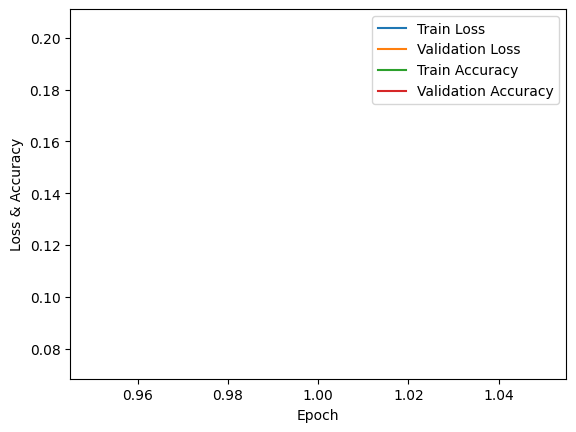

100%|██████████| 275/275 [39:28<00:00,  8.61s/it]


Epoch 2 모델 저장이 완료되었습니다.
Epoch 2, Training Loss: 0.07916323453187943, Training Accuracy: 0.13245776097342005,           Validation Loss: 0.05915358803302945, Validation Accuracy: 0.14169871448958893


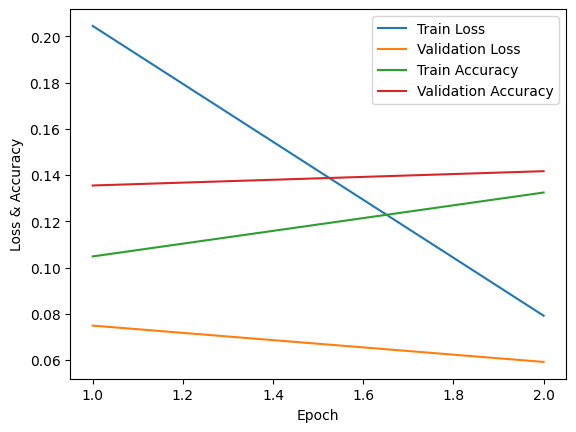

100%|██████████| 275/275 [38:36<00:00,  8.42s/it]


Epoch 3, Training Loss: 0.06906378359957174, Training Accuracy: 0.13882380218644955,           Validation Loss: 0.05094803511584777, Validation Accuracy: 0.13993108528366416


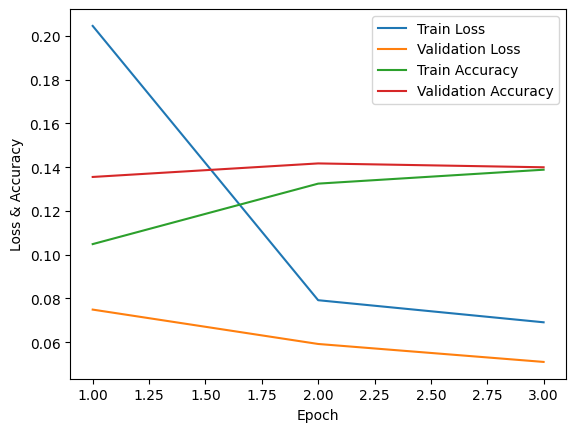

100%|██████████| 275/275 [38:09<00:00,  8.33s/it]


Epoch 4 모델 저장이 완료되었습니다.
Epoch 4, Training Loss: 0.06199721777980978, Training Accuracy: 0.13955306659096897,           Validation Loss: 0.053144867040312856, Validation Accuracy: 0.14265217596880866


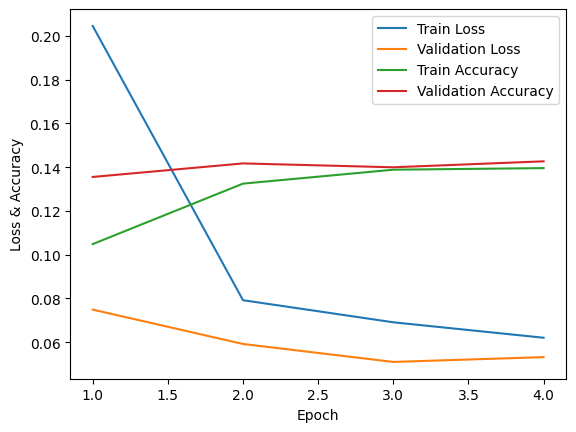

100%|██████████| 275/275 [38:39<00:00,  8.43s/it]


Epoch 5 모델 저장이 완료되었습니다.
Epoch 5, Training Loss: 0.05887760725888339, Training Accuracy: 0.144904912985121,           Validation Loss: 0.055211301972937686, Validation Accuracy: 0.1473582189993797


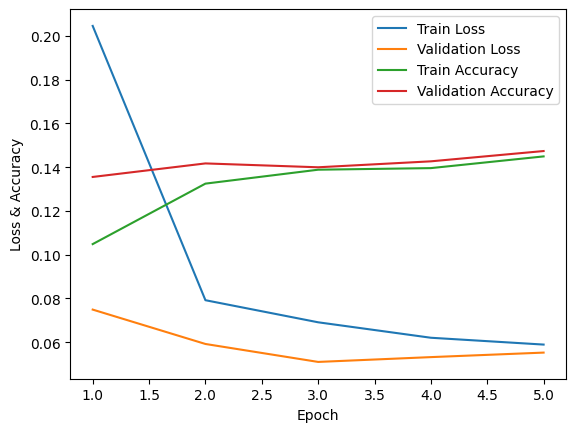

100%|██████████| 275/275 [37:58<00:00,  8.29s/it]


Epoch 6 모델 저장이 완료되었습니다.
Epoch 6, Training Loss: 0.05465522684156895, Training Accuracy: 0.14587608553000547,           Validation Loss: 0.04490060650227919, Validation Accuracy: 0.14841639637435455


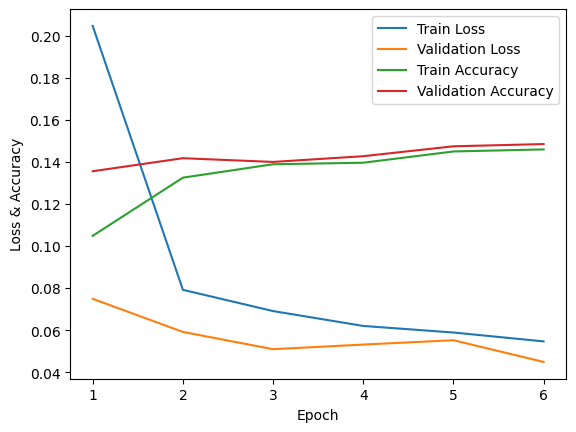

100%|██████████| 275/275 [38:45<00:00,  8.46s/it]


Epoch 7, Training Loss: 0.052732816778800706, Training Accuracy: 0.14714917206394748,           Validation Loss: 0.04987403993442847, Validation Accuracy: 0.14668381981583625


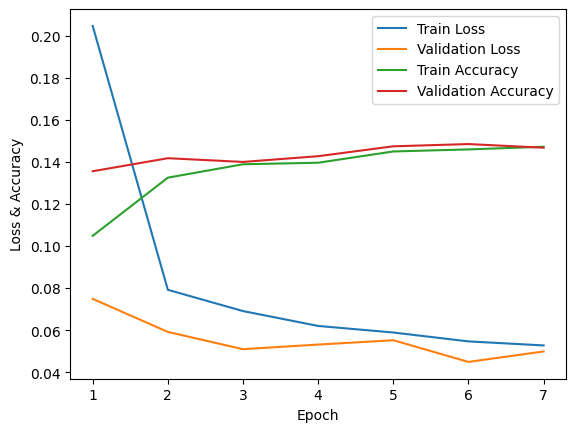

100%|██████████| 275/275 [38:56<00:00,  8.50s/it]


Epoch 8 모델 저장이 완료되었습니다.
Epoch 8, Training Loss: 0.04996116802096367, Training Accuracy: 0.14868496848761004,           Validation Loss: 0.05119472770859755, Validation Accuracy: 0.15199245403764586


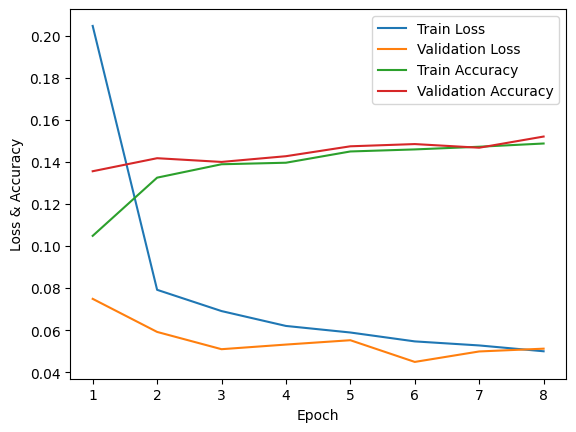

100%|██████████| 275/275 [38:36<00:00,  8.43s/it]


Epoch 9, Training Loss: 0.04999850717457858, Training Accuracy: 0.15000969426894906,           Validation Loss: 0.053879636167968294, Validation Accuracy: 0.14599529151752783


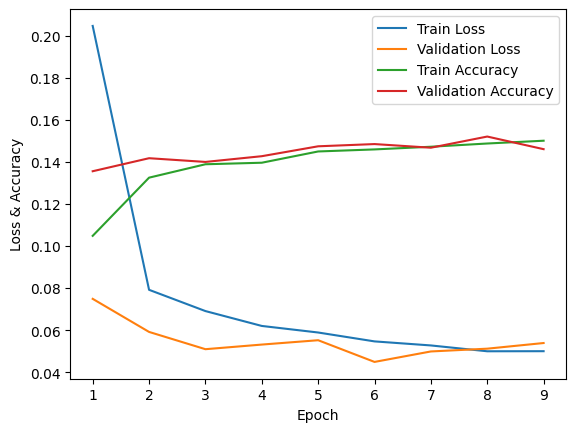

100%|██████████| 275/275 [38:28<00:00,  8.40s/it]


Epoch 10, Training Loss: 0.05021942595189268, Training Accuracy: 0.1469926025613178,           Validation Loss: 0.04760722438664907, Validation Accuracy: 0.15111430417826247


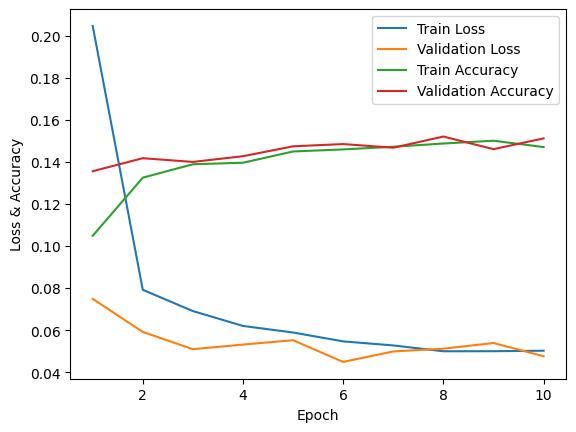

100%|██████████| 275/275 [39:16<00:00,  8.57s/it]


Epoch 11, Training Loss: 0.049293963211503894, Training Accuracy: 0.14973343646624138,           Validation Loss: 0.04537684649484863, Validation Accuracy: 0.148545621290739


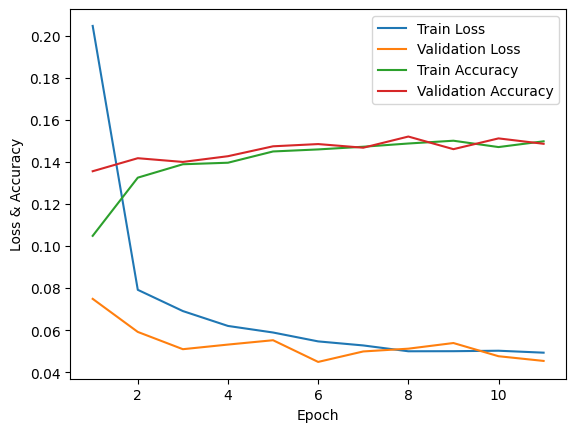

100%|██████████| 275/275 [38:57<00:00,  8.50s/it]


Epoch 12, Training Loss: 0.0459614892845804, Training Accuracy: 0.15172855443267683,           Validation Loss: 0.04954027090333562, Validation Accuracy: 0.14813350300932135


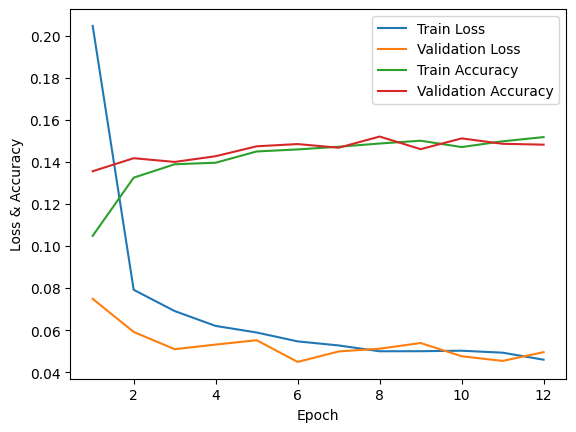

100%|██████████| 275/275 [38:32<00:00,  8.41s/it]


Epoch 13, Training Loss: 0.043659996329383416, Training Accuracy: 0.15391270681848934,           Validation Loss: 0.04695696140691446, Validation Accuracy: 0.15027690445404707


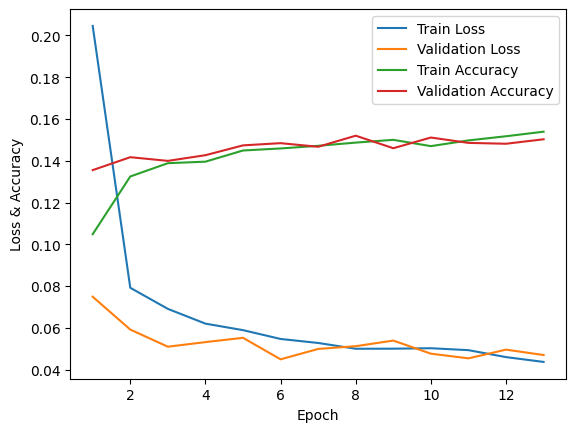

100%|██████████| 275/275 [36:06<00:00,  7.88s/it]


Epoch 14 모델 저장이 완료되었습니다.
Epoch 14, Training Loss: 0.045933120812882075, Training Accuracy: 0.15359419872245683,           Validation Loss: 0.04789128624574309, Validation Accuracy: 0.16019496999585064


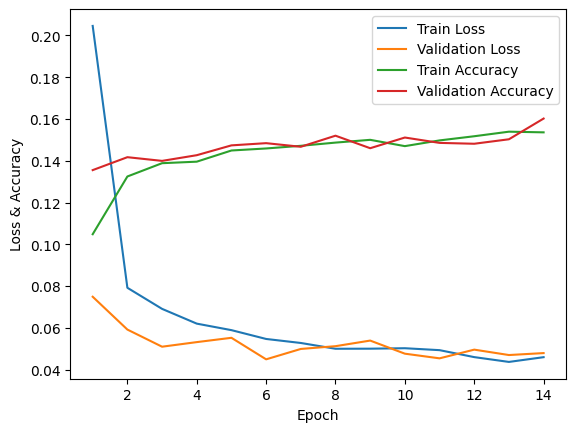

100%|██████████| 275/275 [35:53<00:00,  7.83s/it]


Epoch 15, Training Loss: 0.04495553442023017, Training Accuracy: 0.15451689992259607,           Validation Loss: 0.04678837315463201, Validation Accuracy: 0.1509966215862225


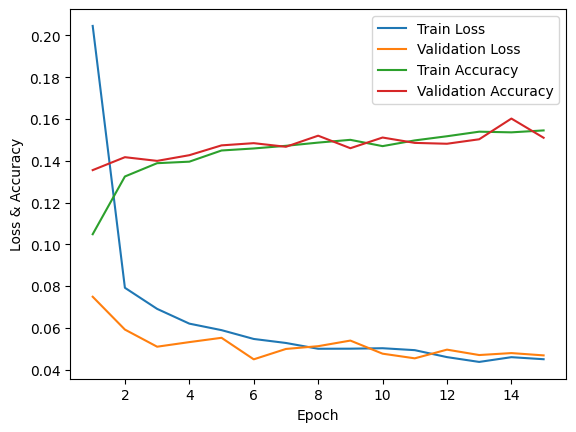

100%|██████████| 275/275 [36:02<00:00,  7.86s/it]


Epoch 16, Training Loss: 0.0426036050780253, Training Accuracy: 0.15010703338094483,           Validation Loss: 0.04530891744108159, Validation Accuracy: 0.1530012859295366


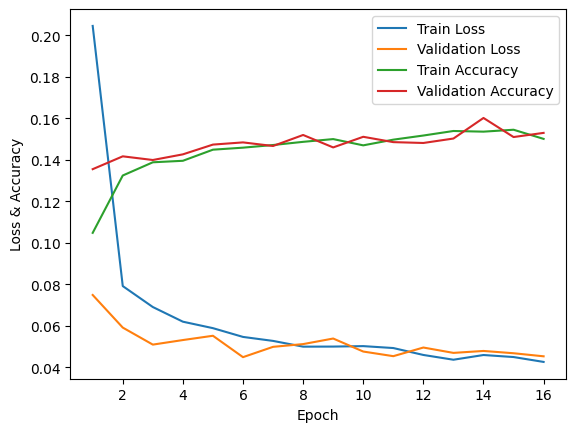

100%|██████████| 275/275 [36:19<00:00,  7.92s/it]


Epoch 17, Training Loss: 0.04491341160102324, Training Accuracy: 0.1568434131938757,           Validation Loss: 0.04859855169902032, Validation Accuracy: 0.15287741468699706


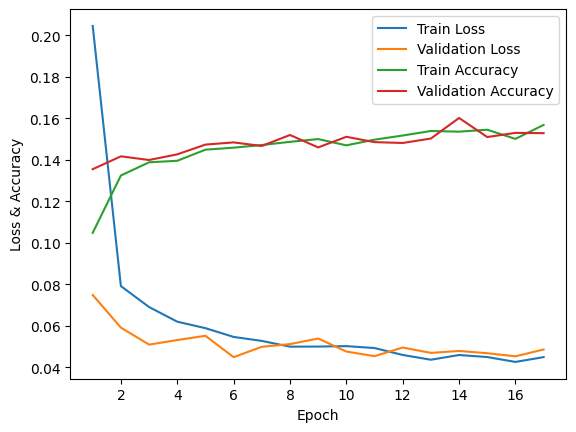

100%|██████████| 275/275 [36:30<00:00,  7.96s/it]


Epoch 18 모델 저장이 완료되었습니다.
Epoch 18, Training Loss: 0.04429812442849983, Training Accuracy: 0.153784345906761,           Validation Loss: 0.04520286737977179, Validation Accuracy: 0.16077308491064243


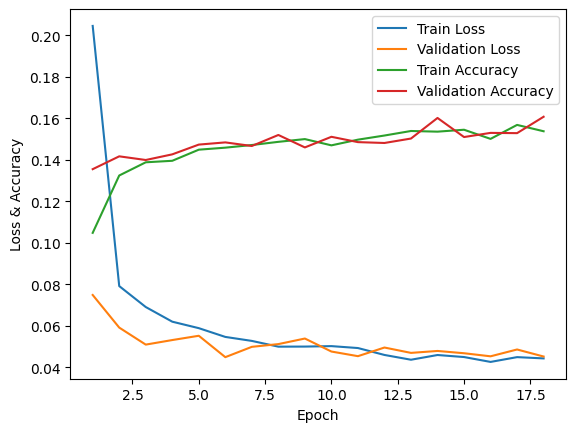

100%|██████████| 275/275 [35:33<00:00,  7.76s/it]


Epoch 19, Training Loss: 0.040213323188099, Training Accuracy: 0.15255703226261608,           Validation Loss: 0.04104400467719131, Validation Accuracy: 0.15443115889258652


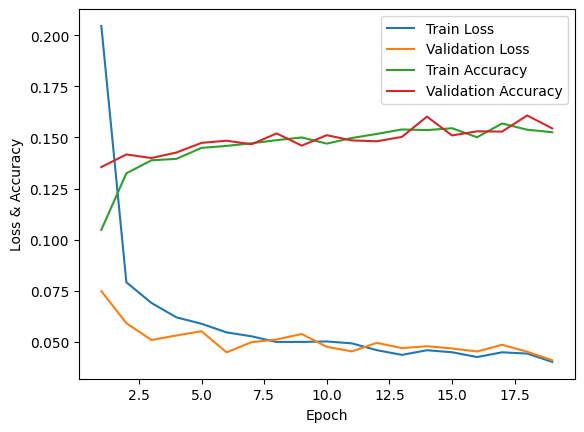

100%|██████████| 275/275 [35:33<00:00,  7.76s/it]


Epoch 20, Training Loss: 0.039567077735608275, Training Accuracy: 0.1551674640276482,           Validation Loss: 0.05203746067352049, Validation Accuracy: 0.14972927437319777


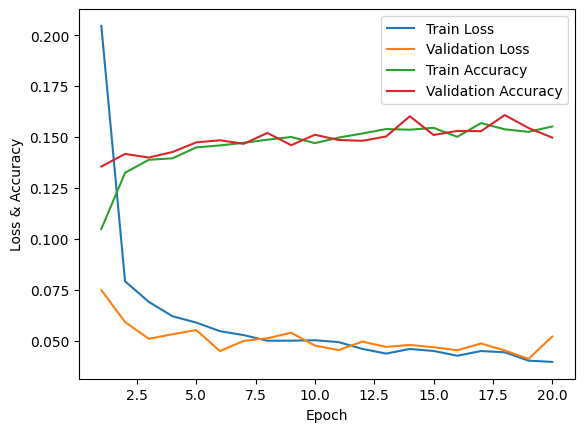

100%|██████████| 275/275 [36:34<00:00,  7.98s/it]


Epoch 21, Training Loss: 0.042464333792979064, Training Accuracy: 0.1503796990393723,           Validation Loss: 0.06380764468545054, Validation Accuracy: 0.13072427250285004


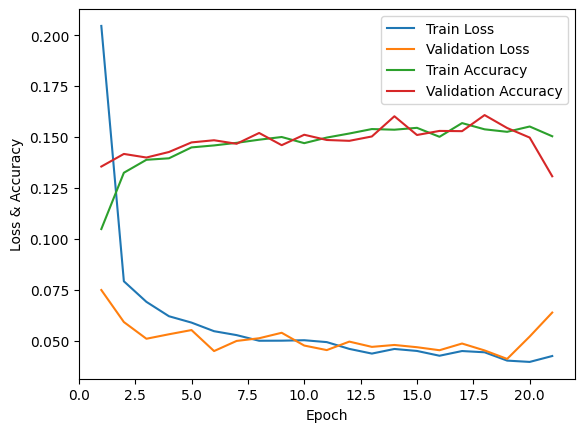

100%|██████████| 275/275 [38:07<00:00,  8.32s/it]


Epoch 22, Training Loss: 0.04392200039191679, Training Accuracy: 0.1511579007589502,           Validation Loss: 0.043397897878429924, Validation Accuracy: 0.1554152198103876


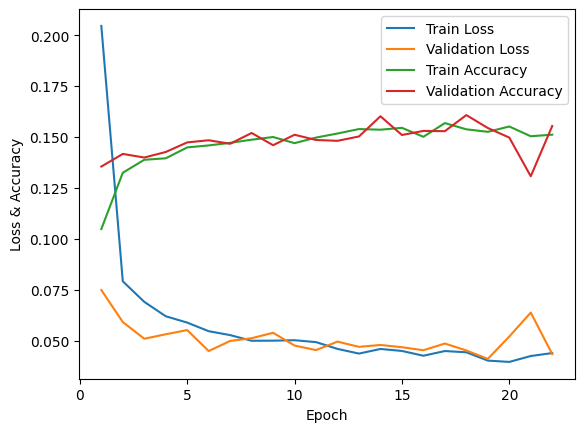

100%|██████████| 275/275 [37:59<00:00,  8.29s/it]


Epoch 23, Training Loss: 0.041713589517907664, Training Accuracy: 0.15577371574687002,           Validation Loss: 0.05559162136822811, Validation Accuracy: 0.1525713711849098


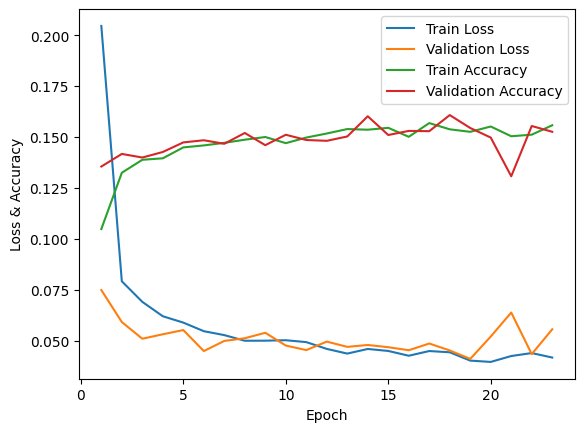

100%|██████████| 275/275 [38:05<00:00,  8.31s/it]


Epoch 24, Training Loss: 0.04168670246546919, Training Accuracy: 0.15385008249482787,           Validation Loss: 0.05169875625632863, Validation Accuracy: 0.13837889642674525


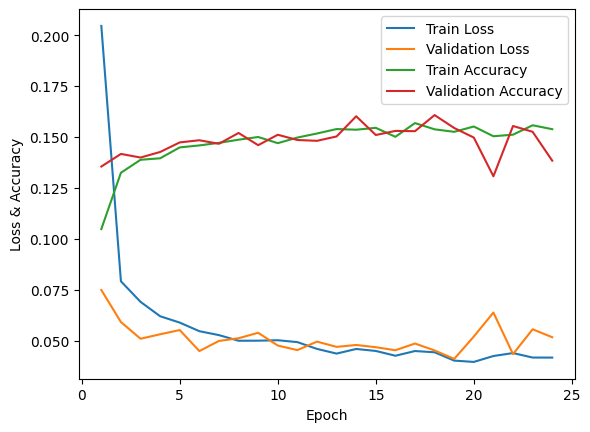

100%|██████████| 275/275 [36:21<00:00,  7.93s/it]


Epoch 25, Training Loss: 0.04078154679049145, Training Accuracy: 0.15629387771203068,           Validation Loss: 0.04090867047657783, Validation Accuracy: 0.14799301409414398


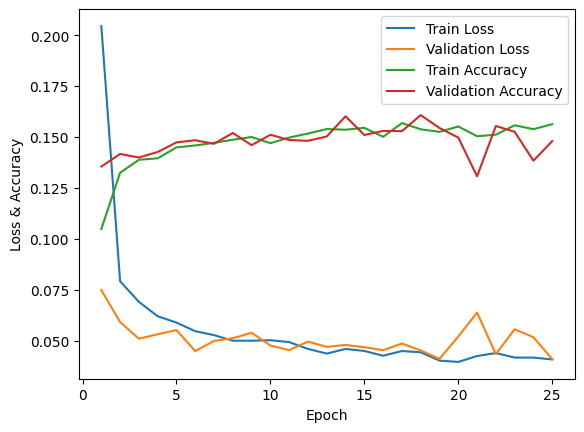

100%|██████████| 275/275 [37:07<00:00,  8.10s/it]


Epoch 26, Training Loss: 0.037402587790380824, Training Accuracy: 0.15310532631608934,           Validation Loss: 0.03978553689344758, Validation Accuracy: 0.15737101346126442


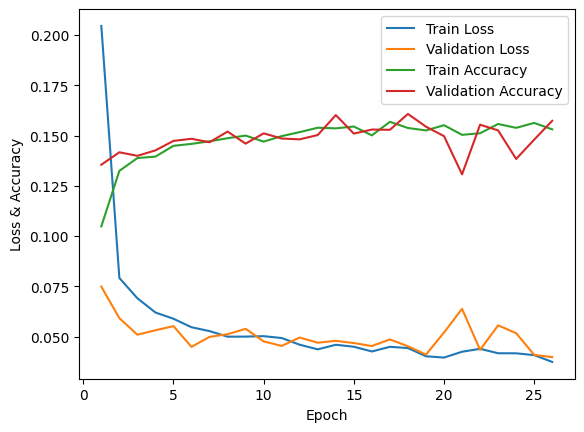

100%|██████████| 275/275 [38:33<00:00,  8.41s/it]


Epoch 27, Training Loss: 0.04290427267551422, Training Accuracy: 0.1568472487554837,           Validation Loss: 0.05107155477412269, Validation Accuracy: 0.14687404714428814


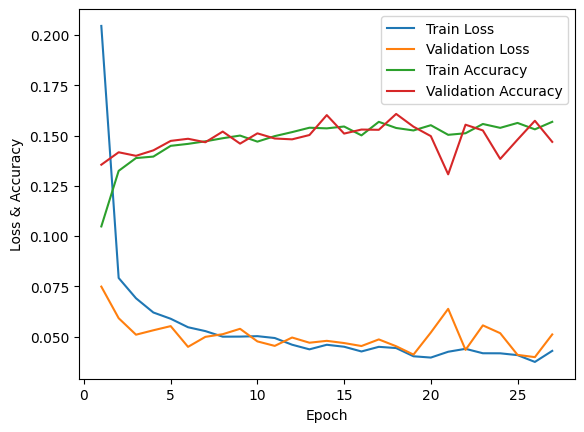

100%|██████████| 275/275 [38:31<00:00,  8.40s/it]


Epoch 28, Training Loss: 0.0429265790364959, Training Accuracy: 0.15287031731827214,           Validation Loss: 0.04455216833322345, Validation Accuracy: 0.14808851250251476


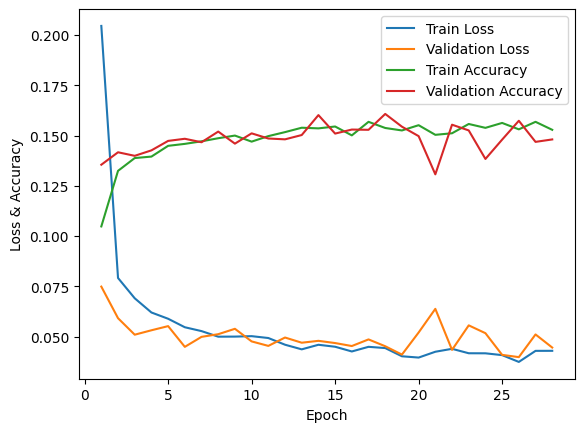

100%|██████████| 275/275 [37:53<00:00,  8.27s/it]


Epoch 29, Training Loss: 0.04172906930473718, Training Accuracy: 0.1535261148958719,           Validation Loss: 0.04124974910281758, Validation Accuracy: 0.15362702725782926


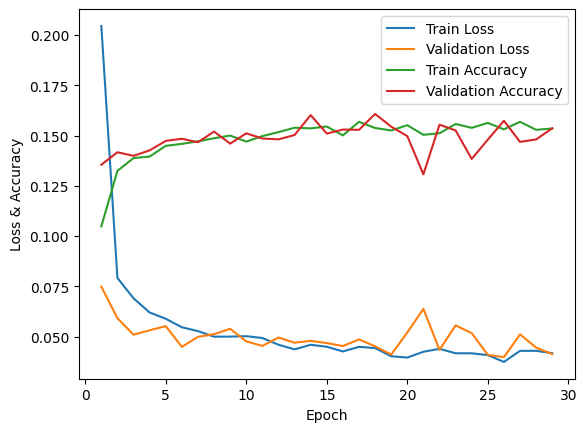

100%|██████████| 275/275 [38:19<00:00,  8.36s/it]


Epoch 30, Training Loss: 0.038608076592737975, Training Accuracy: 0.15475529589866005,           Validation Loss: 0.04312012629191763, Validation Accuracy: 0.16020656143646894


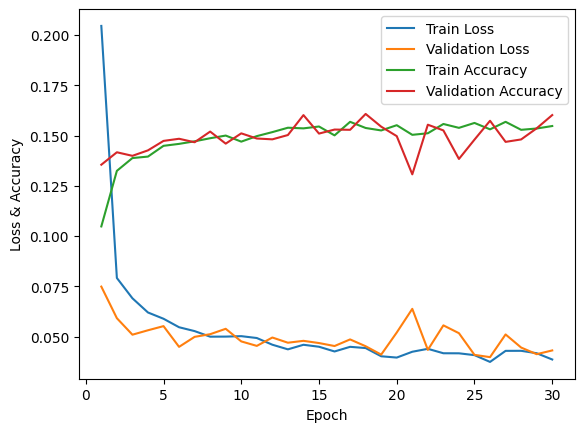

100%|██████████| 275/275 [38:09<00:00,  8.33s/it]


Epoch 31, Training Loss: 0.038289640579711307, Training Accuracy: 0.1568301886781955,           Validation Loss: 0.04231201019537807, Validation Accuracy: 0.1502166879023605


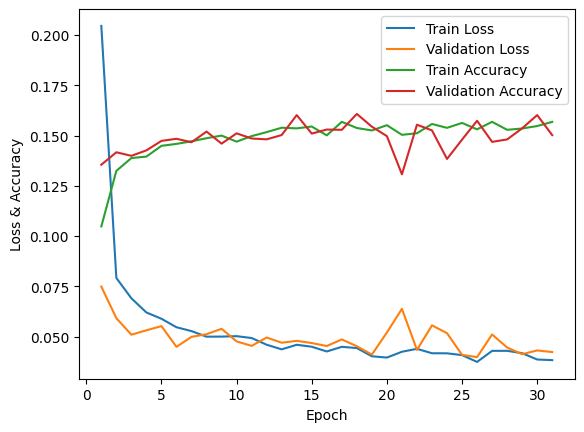

100%|██████████| 275/275 [38:53<00:00,  8.49s/it]


Epoch 32, Training Loss: 0.03740764590826901, Training Accuracy: 0.15724871347682956,           Validation Loss: 0.03941310235487033, Validation Accuracy: 0.1546316842664465


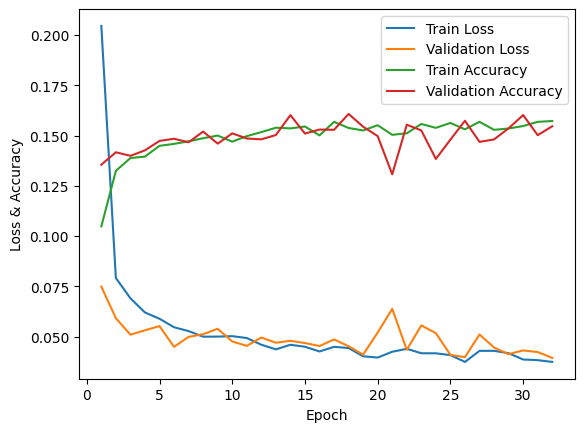

100%|██████████| 275/275 [39:13<00:00,  8.56s/it]


Epoch 33, Training Loss: 0.036817673952742054, Training Accuracy: 0.15664344238169972,           Validation Loss: 0.04033012250078594, Validation Accuracy: 0.15042176471759322


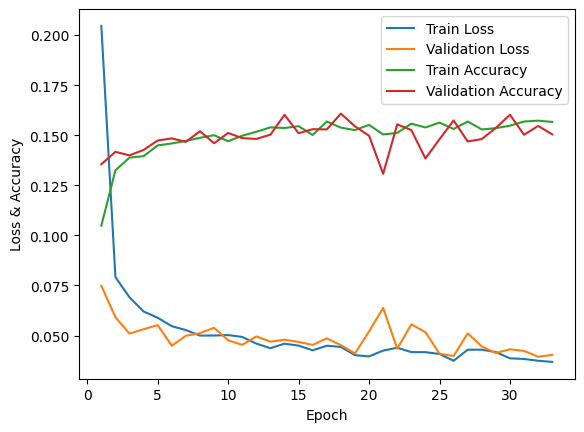

100%|██████████| 275/275 [39:19<00:00,  8.58s/it]


Epoch 34, Training Loss: 0.03474130971526558, Training Accuracy: 0.15478759042327797,           Validation Loss: 0.041909425363520186, Validation Accuracy: 0.14912974476302643


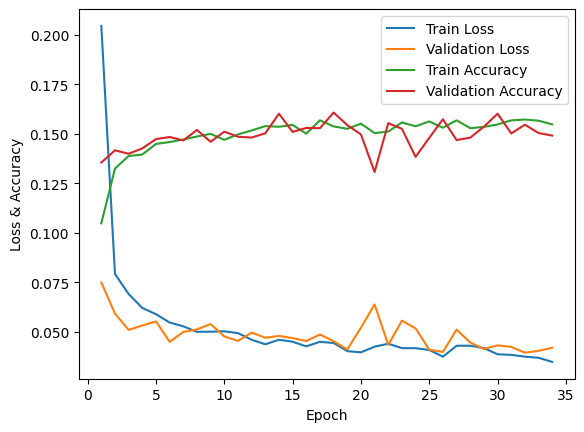

100%|██████████| 275/275 [39:12<00:00,  8.55s/it]


Epoch 35, Training Loss: 0.035615224641832435, Training Accuracy: 0.15294119348934596,           Validation Loss: 0.041541019926255356, Validation Accuracy: 0.15414769250435892


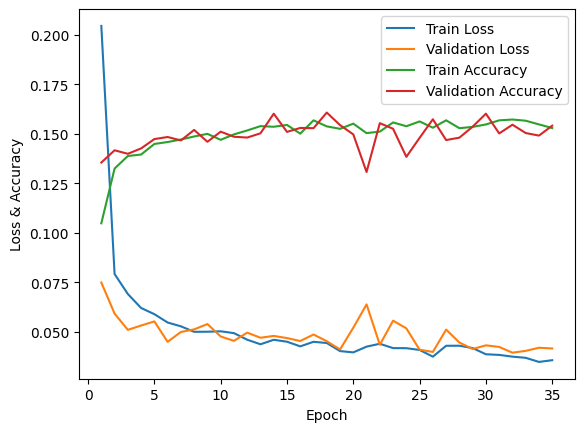

100%|██████████| 275/275 [39:23<00:00,  8.59s/it]


Epoch 36, Training Loss: 0.040058017704974525, Training Accuracy: 0.15657597753060548,           Validation Loss: 0.060730836709937314, Validation Accuracy: 0.14465328756831747


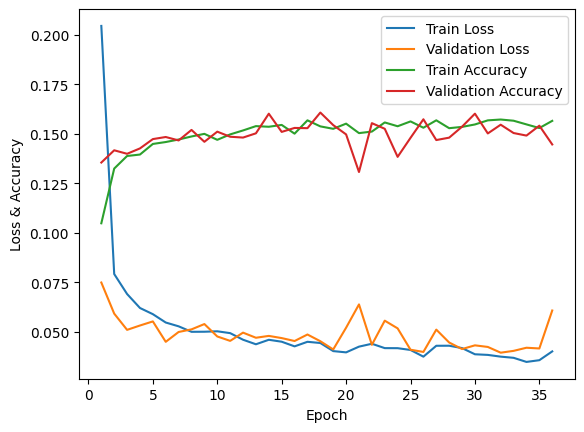

100%|██████████| 275/275 [39:21<00:00,  8.59s/it]


Epoch 37, Training Loss: 0.03727187050337141, Training Accuracy: 0.1563118732073357,           Validation Loss: 0.04760724462792597, Validation Accuracy: 0.14850758892272165


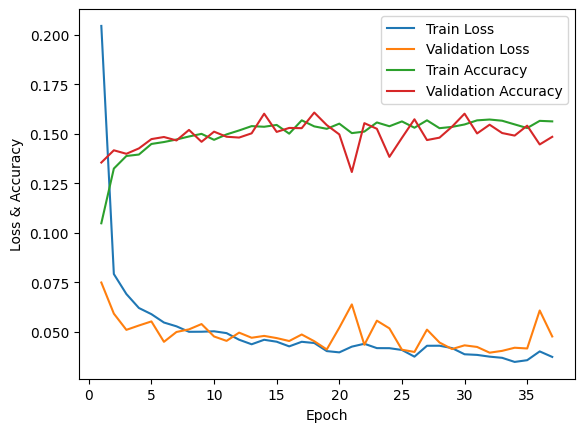

100%|██████████| 275/275 [39:25<00:00,  8.60s/it]


검증 정확도가 20 에폭 이상 개선되지 않아 학습을 중단합니다.


In [15]:
# load_model(model, "./save/psp_dense_dice_aug/trained_epoch22.pth")

best_val_accuracy = float('-inf')
patience = 20  # 최소 검증 손실값이 patience 번째 이후로 개선되지 않으면 학습 중단
counter = 0

for epoch in range(50):
    epoch+=1
    model.train()
    epoch_loss = 0
    correct_pixels_train = 0
    total_pixels_train = 0

    transform = A.Compose(
        [   
            A.ColorJitter(p=0.3),
            A.Downscale(p=0.3),
            A.Equalize(p=0.3),
            A.HueSaturationValue(p=0.3),
            A.ToGray(p=0.15),
            Fisheye(p=1.0, csv_path="./train_source.csv"),
            A.Spatter(p=0.25),
            A.Defocus(p=0.1),
            A.Perspective(p=0.2),
            A.Resize(256, 512),
            A.Normalize(),
            ToTensorV2()
        ]
    )

    val_transform = A.Compose(
        [   
            A.ColorJitter(p=0.3),
            A.Downscale(p=0.3),
            A.Equalize(p=0.3),
            A.HueSaturationValue(p=0.3),
            A.ToGray(p=0.15),
            Fisheye(p=1.0, csv_path="./val_source.csv"),
            A.Spatter(p=0.25),
            A.Defocus(p=0.1),
            A.Perspective(p=0.2),
            A.Resize(256, 512),
            A.Normalize(),
            ToTensorV2()

        ]
    )

    dataset = CustomDataset(csv_file='./train_source.csv', transform=transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    val_dataset = CustomDataset(csv_file='./val_source.csv', transform=val_transform)  # validation 데이터셋 로딩
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        predicted_masks_train = torch.argmax(outputs, dim=1)  # Get predicted class labels
        correct_pixels_train += (predicted_masks_train == masks).sum().item()
        total_pixels_train += masks.numel()

    epoch_loss /= len(dataloader)
    accuracy_train = correct_pixels_train / total_pixels_train

    # Validation loop
    model.eval()
    total_validation_loss = 0.0
    correct_pixels_val = 0
    total_pixels_val = 0

    with torch.no_grad():
        for val_images, val_masks in val_dataloader:
            val_images = val_images.float().to(device)
            val_masks = val_masks.long().to(device)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)

            total_validation_loss += val_loss.item() * val_images.size(0)

            predicted_masks_val = torch.argmax(val_outputs, dim=1)  # Get predicted class labels
            correct_pixels_val += (predicted_masks_val == val_masks).sum().item()
            total_pixels_val += val_masks.numel()

    average_validation_loss = total_validation_loss / len(val_dataset)
    accuracy_val = correct_pixels_val / total_pixels_val

    if accuracy_val > best_val_accuracy:
        best_val_accuracy = accuracy_val
        counter = 0
        save_path = save_dir + model_name.format(epoch)
        torch.save(model.state_dict(), save_path)
        print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")
    else:
        counter += 1

    if counter >= patience:
        print(f"검증 정확도가 {patience} 에폭 이상 개선되지 않아 학습을 중단합니다.")
        break

    print(f'Epoch {epoch}, Training Loss: {epoch_loss}, Training Accuracy: {accuracy_train}, \
          Validation Loss: {average_validation_loss}, Validation Accuracy: {accuracy_val}')

    train_losses.append(epoch_loss)
    val_losses.append(average_validation_loss)

    train_accuracies.append(accuracy_train)
    val_accuracies.append(accuracy_val)

    train_losses_np = torch.tensor(train_losses).cpu().numpy()
    val_losses_np = torch.tensor(val_losses).cpu().numpy()
    train_accuracies_np = torch.tensor(train_accuracies).cpu().numpy()
    val_accuracies_np = torch.tensor(val_accuracies).cpu().numpy()

    plt.plot(range(1, len(train_losses_np) + 1), train_losses_np, label='Train Loss')
    plt.plot(range(1, len(val_losses_np) + 1), val_losses_np, label='Validation Loss')
    plt.plot(range(1, len(train_accuracies_np) + 1), train_accuracies_np, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies_np) + 1), val_accuracies_np, label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Loss & Accuracy')
    plt.legend()
    plt.show()

In [ ]:
# print(train_losses)
# print(val_losses)

# train_losses.pop()
# val_losses.pop()

# print(len(train_losses))
# print(val_losses)

# Load Model

In [6]:
# 모델 생성
model = smp.FPN(encoder_name="resnet101",  # 필수 파라미터: 사용할 인코더 백본의 이름
    in_channels=3,    # 필수 파라미터: 입력 이미지의 채널 수 (일반적으로 3(RGB) 또는 1(Grayscale))
    classes=13,        # 필수 파라미터: 세그멘테이션 클래스의 수 (예: 물체 탐지의 경우 물체 클래스 수)
    encoder_weights="imagenet"  # 선택적 파라미터: 사용할 사전 훈련된 인코더 가중치의 경로 또는 'imagenet'으로 설정하여 ImageNet 가중치 사용
)

# 저장된 모델의 파라미터 불러오기 (strict=False 옵션 사용)
state_dict = torch.load('./save/fpn_resnet_real_aug/trained_epoch18.pth', map_location=torch.device('cpu'))

# 저장된 모델의 클래스 수 (1개의 클래스일 때)
saved_num_classes = 13

# 현재 모델의 클래스 수 (예시로 21로 설정, 실제 사용하는 클래스 수로 수정)
current_num_classes = 13

# 모델의 분류기 레이어 크기 변경
if saved_num_classes != current_num_classes:
    # 모델의 분류기 레이어를 1x1 컨볼루션 레이어로 수정
    model.classifier[4] = torch.nn.Conv2d(256, current_num_classes, kernel_size=(1, 1), stride=(1, 1))
    # 모델의 분류기 레이어를 초기화
    torch.nn.init.xavier_uniform_(model.classifier[4].weight)  # 또는 다른 초기화 방법 사용

# 모델의 파라미터 로드
model.load_state_dict(state_dict, strict=False)

# GPU 사용이 가능한 경우에는 GPU로 데이터 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

# Inference

In [7]:
# albumentations 라이브러리를 사용하여 이미지 데이터에 대한 변환(transform) 파이프라인 정의
transform = A.Compose(
    [
        # Fisheye(p=1.0),
        A.Resize(256, 512), # 이미지 크기 조정
        A.Normalize(),  # 이미지 픽셀값 정규화
        ToTensorV2() # 이미지를 텐서로 변환
    ]
)

test_dataset = CustomDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()
        # batch에 존재하는 각 이미지에 대해서 반복
        for idx, pred in enumerate(outputs):
            pred = pred.astype(np.uint8)
            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환
            
            # # 원본 이미지 및 예측 이미지 출력
            # plt.figure(figsize=(15, 10))
            # plt.subplot(1, 2, 1)
            # plt.imshow(images[idx].cpu().numpy().transpose(1, 2, 0))
            # plt.title("Original Image")
            
            # plt.subplot(1, 2, 2)
            # plt.imshow(pred) # 예측 이미지의 cmap을 'jet'으로 설정하여 클래스 구분을 쉽게 함
            # plt.title("Predicted Mask")
            
            # plt.show()
            
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

  0%|          | 0/238 [00:00<?, ?it/s]d:\Users\admin\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 238/238 [03:29<00:00,  1.14it/s]


# Visualize Validation

  0%|          | 0/59 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


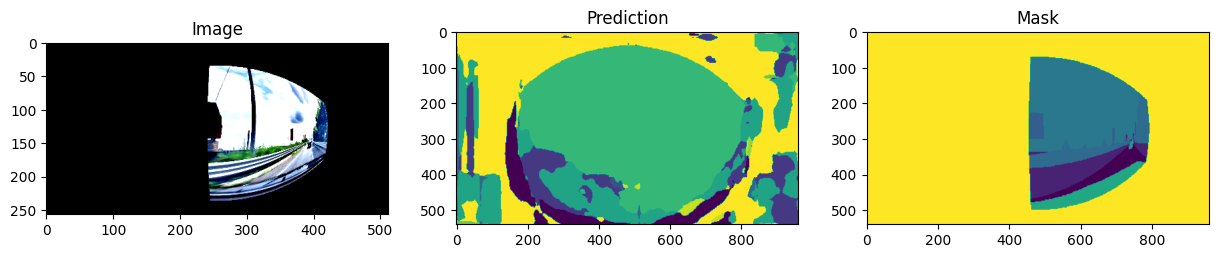

  2%|▏         | 1/59 [00:05<05:46,  5.98s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


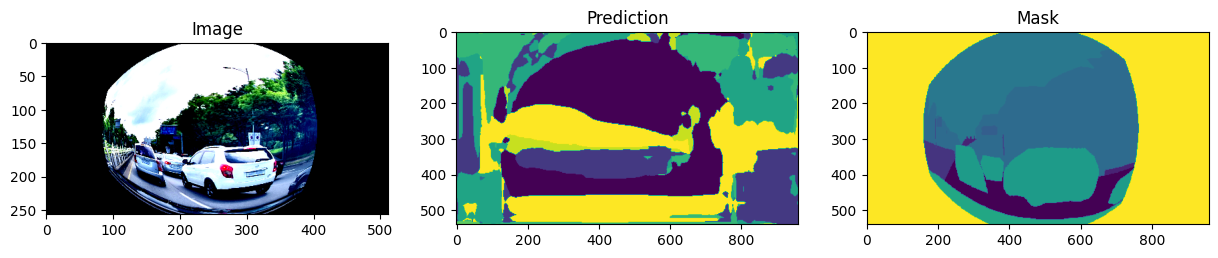

  3%|▎         | 2/59 [00:12<06:11,  6.51s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


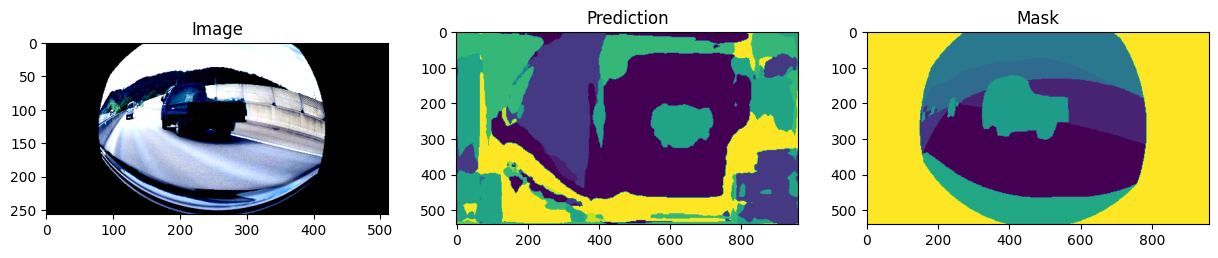

  5%|▌         | 3/59 [00:18<05:54,  6.32s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


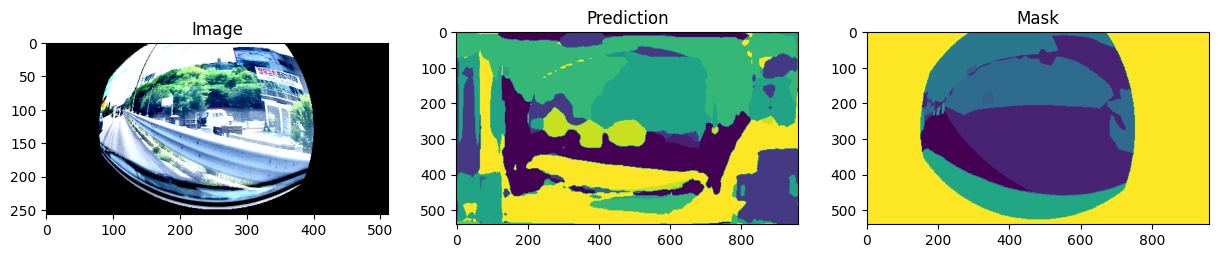

  7%|▋         | 4/59 [00:25<05:44,  6.26s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


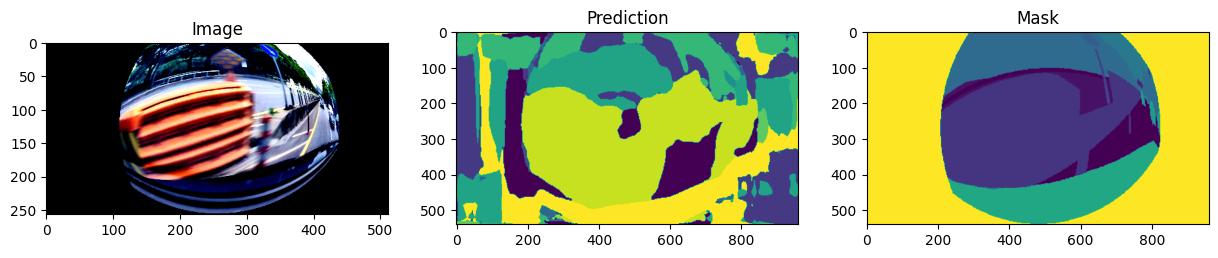

  8%|▊         | 5/59 [00:33<05:59,  6.66s/it]


KeyboardInterrupt: 

In [17]:
# albumentations 라이브러리를 사용하여 이미지 데이터에 대한 변환(transform) 파이프라인 정의
transform = A.Compose(
    [
        Fisheye(p=1.0),
        A.CenterCrop(height=672,width=1344,p=1.0),
        A.Resize(256, 512), # 이미지 크기 조정
        A.Normalize(),  # 이미지 픽셀값 정규화
        ToTensorV2() # 이미지를 텐서로 변환
    ]
)

test_dataset = CustomDataset(csv_file='./val_source.csv', transform=transform, infer=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    model.eval()
    result = []
    for images, masks in tqdm(test_dataloader):
        images = images.float().to(device)
        img1 = np.transpose(np.array(images[0, :, :, :].to('cpu')), (1, 2, 0))

        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()

        for pred in outputs:
            pred = pred.astype(np.uint8)
            pred_resized = Image.fromarray(pred).resize((960, 540), Image.NEAREST)
            pred_resized = np.array(pred_resized)

            mask1 = np.array(masks[0, :, :])
            mask1_resized = Image.fromarray(mask1).resize((960, 540), Image.NEAREST)
            mask1_resized = np.array(mask1_resized)

            for class_id in range(12):
                class_mask = (pred_resized == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0:
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else:
                    result.append(-1)
            
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img1)
        plt.title("Image")

        plt.subplot(1, 3, 2)
        plt.imshow(pred_resized)
        plt.title("Prediction")

        plt.subplot(1, 3, 3)
        plt.imshow(mask1_resized)
        plt.title("Mask")
        
        plt.show()


# Submission

In [8]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,202960 4 203920 4 204867 92 205827 92 206784 9...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,1 2 595 368 1555 370 2513 372 3473 376 4433 37...
3,TEST_0000_class_3,219170 11 220130 11 221075 26 222035 26 222978...
4,TEST_0000_class_4,403225 4 404185 4 405144 9 406104 9 407062 11 ...
...,...,...
22771,TEST_1897_class_7,48 13 1008 13 1968 9 2928 9 3890 5 4850 5 1310...
22772,TEST_1897_class_8,61 572 685 109 1021 572 1645 109 1977 574 2607...
22773,TEST_1897_class_9,274544 2 275504 2 276464 2 277424 2 278386 2 2...
22774,TEST_1897_class_10,-1


In [9]:
submit.to_csv('./submit.csv', index=False)